In [16]:
import cv2 as cv
import numpy as np
import os
import pandas
import random
from ipywidgets import widgets
from ipywidgets import interact,interactive, fixed
from IPython.display import Image, display, clear_output


import ipywidgets

path="/Users/fgimbert/Documents/Dataset/Manual/Preprocessed/"

def loadData(folderPictures=path):

    folders=next(os.walk(folderPictures))[1]

    img_groups = {}
    img_list={}

    for folder in folders:
        for img_file in os.listdir(folderPictures+folder):
            name, label = img_file.strip('.png').split("_")

            # One image per class

            #if label not in img_groups.keys():
            #    img_groups[label] = [folder + "_" + name]


            # Multiple images per class

            if label in img_groups.keys():
                img_groups[label].append(folder+"_"+name)
            else:
                img_groups[label] = [folder+"_"+name]

            img_list[folder+"_"+name]=[label]
            
    # Extract only N hieroglyph classes randomly

    nclass = len(img_groups.keys())

    list_of_class = random.sample(list(img_groups.keys()), nclass)
    #print(list_of_class)

    short_dico = {x: img_groups[x] for x in list_of_class if x in img_groups}

    dataHiero=pandas.DataFrame.from_dict(img_list,orient='index')
    dataHiero.columns = ["label"]
    dataHiero = dataHiero[dataHiero.label != 'UNKNOWN']

    dataHiero = dataHiero.loc[dataHiero['label'].isin(short_dico)]


    dataHiero.reset_index(level=0, inplace=True)

    return dataHiero,img_groups


In [17]:

img_width, img_height = 50, 75
input_shape=(img_width, img_height, 1)

dataHiero, dictLabels=loadData(path)

print(dataHiero.head())
print(len(dataHiero)," hieroglyphs !")
print(len(dictLabels.keys())," different hieroglyphs  !")

       index label
0  20_200000   S29
1  20_200001   V13
2  20_200002   V13
3  20_200003   G43
4  20_200004   D21
4031  hieroglyphs !
172  different hieroglyphs  !


In [18]:

def check_cluster():
    
    
        
    #print('Cluster ', cluster)
    
    #img = mpimg.imread(picture)
    img = cv.imread(picture)
    #print(cluster)
    #print(unknown_pix)
    #print(unknown_pix[cluster])
    #print(good_clusters, bad_clusters, maybe_clusters)


    x, y, w, h = cv.boundingRect(result_dbscan[1][unknown_pix[cluster]])
    cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    #print(x, y, w, h)
    #plt.imshow(img)
    cv.imwrite('tempfile.png', img)
    #time.sleep(3)
    
    question = widgets.Label(value='Is it a hieroglyph ?')
    #number_cluster = widgets.Text(value='{}'.format(cluster), description='Cluster',disabled=True)

    button1 = widgets.Button(description = 'Yes', button_style='success')
    button2 = widgets.Button(description = 'No', button_style='danger')
    button3 = widgets.Button(description = 'Maybe', button_style='warning')
    
    container = widgets.HBox([question, button1,button2,button3])

    hiero_img = interactive(show_img, name=fixed('tempfile.png'))
    
    hiero_check = widgets.VBox([container, hiero_img])
    display(hiero_check)

    def on_button1_clicked(b):
        # [insert code to record choice]
        global check_done
        check_done = True
        global cluster
        
        hiero_img.close()
        container.close()
        clear_output()
        good_clusters.append(unknown_pix[cluster])
        global hiero_detected
        global pos_detected
        hiero_detected.append(result_dbscan[1][unknown_pix[cluster]])
        pos_detected.append([x, y, w, h])
        
        cluster += 1
        if cluster ==len(result_dbscan[1]):
            if len(unknown_pix) == 0:
                print('Run Hieroglyph recognition now !')
                hiero_check.close()
            else:
                print('Change DBSCAN scale !')
                hiero_check.close()
        else:
            
            check_cluster()

    def on_button2_clicked(b):
        # [insert code to record choice]
        global check_done
        check_done = True
        global cluster
        
        hiero_img.close()
        container.close()
        clear_output()
        bad_clusters.append(unknown_pix[cluster])
        
        cluster +=1
        
        if cluster ==len(result_dbscan[1]):
            if len(unknown_pix) == 0:
                print('Run Hieroglyph recognition now !')
                hiero_check.close()
            else:
                print('Change DBSCAN scale !')
                hiero_check.close()
                
        else:
            
            check_cluster()
            
    def on_button3_clicked(b):
        # [insert code to record choice] 
        global cluster
        
        hiero_img.close()
        container.close()
        clear_output()
        maybe_clusters.append(unknown_pix[cluster])
        cluster +=1
        
        if cluster == len(result_dbscan[1]):
            print('Job finished')
            hiero_check.close()
        else:
            check_cluster()

    button1.on_click(on_button1_clicked)
    button2.on_click(on_button2_clicked)
    button3.on_click(on_button3_clicked)
    
    
    

In [22]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(np.maximum(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv.Canny(image, lower, upper)
    # return the edged image
    return edged

def threshold_otsu(image):
    img_input = cv.imread(image)
    img_gray = cv.cvtColor(img_input, cv.COLOR_BGR2GRAY)
    #blur = cv.medianBlur(img, 3)
    blur = cv.GaussianBlur(img_gray,(5,5),0)
    ret3, otsu = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    otsu_blur = auto_canny(otsu)
    
    return otsu_blur

def threshold_canny(image):
    img_input = cv.imread(image)
    img_gray = cv.cvtColor(img_input, cv.COLOR_BGR2GRAY)
    #edges = cv.Canny(img,80,500)
    blur = cv.GaussianBlur(img_gray,(7,7),0)
    #blur = cv.medianBlur(img, 3)
    auto_blur = auto_canny(blur)
    return auto_blur

In [20]:
def pixels_white(image):
    
    #Find all white pixel in picture_canny
    indices = np.where(image == [255])
    coordinates = np.hstack((indices[1].reshape(-1,1),indices[0].reshape(-1,1)))
    #print(coordinates.shape)

    return coordinates


def pixels_dbscan(coord, eps=3, sizemin = 5):

    # DBSCAN on coordinates
    from sklearn.cluster import DBSCAN

    clustering = DBSCAN(eps, min_samples=2).fit(coord)
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    cluster_dict = {i: coord[clustering.labels_ == i] for i in range(n_clusters_)}
    cluster_size = {i: len(cluster_dict[i]) for i in range(n_clusters_)}
    cluster_dim={}
    
    
    for i in range(n_clusters_):
        x, y, w, h = cv.boundingRect(cluster_dict[i])
        cluster_dim[i] = [x, y, w, h, w*h]


    remove_clusters = [k for k in cluster_dict if cluster_size[k] <= sizemin]

    for k in remove_clusters: 
        del cluster_dict[k]
        del cluster_size[k]
        del cluster_dim[k]
    
    n_clusters_ = len(cluster_size)
    
    #img = mpimg.imread(picture)
    img_thre = cv.imread('img_threshold.png')
    
    #print(x, y, w, h)
    for c in cluster_dim:
        #x, y, w, h = cv.boundingRect(cluster_dict[cluster])
        cv.rectangle(img_thre,(cluster_dim[c][0],cluster_dim[c][1]),(cluster_dim[c][0]+cluster_dim[c][2],cluster_dim[c][1]+cluster_dim[c][3]),(0,255,0),2)
        
    cv.imwrite('out_dbscan.png', img_thre)



       # for pixel in result_dbscan[1][cluster]:
         #   canvas[pixel[1]][pixel[0]] = np.array([100+10*cluster,255-cluster,30*cluster])

#cv.drawContours(img, [np.array(cluster_dict[0]).reshape(-1,1,2).astype(np.int32)], 0, (0,255,0),2 )
    unknown_clusters = list(cluster_dict.keys())
    
    return [n_clusters_, cluster_dict, cluster_size, eps], unknown_clusters

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec
from skimage.measure import compare_ssim
plt.rcParams['figure.figsize']=[10,7]

from ipywidgets import Image, Layout
examples = ['example0.png','example1.png','example2.jpg','example3.jpg','example4.jpg']

#example = 4
#picture='/Users/fgimbert/Documents/Hieroglyphs/examples/{}'.format(examples[example])
#img = cv.imread(picture)

#img=mpimg.imread(picture)
#imgplot = plt.imshow(img)
check_done = False
#cluster =0
def choose_img(Name, Edge, DBSCAN, scale, sizemin):
    #global img
    global picture
    picture='.//examples/{}'.format(Name)
    img = mpimg.imread(picture)
    plt.axis('off')
    
    global img_threshold
    
    if not DBSCAN:
        if Edge == 'Otsu':
            img_threshold = threshold_otsu(picture)
            plt.imshow(img_threshold)
            cv.imwrite('img_threshold.png', img_threshold)
        elif Edge == 'AutoCanny':
            img_threshold = threshold_canny(picture)
            plt.imshow(img_threshold)
            cv.imwrite('img_threshold.png', img_threshold)

        elif Edge == 'Normal': 
            plt.imshow(img)
            cv.imwrite('img_threshold.png', img)
    else:
        if not check_done:
            global white_pix
            white_pix = pixels_white(img_threshold)
            global result_dbscan
            global unknown_pix
            global maybe_clusters
            global good_clusters
            global bad_clusters
            global hiero_detected
            global pos_detected


            global cluster
            
            good_clusters = []
            bad_clusters = []
            maybe_clusters = []
            hiero_detected = []
            pos_detected = []
            
            result_dbscan, unknown_pix = pixels_dbscan(white_pix, scale, sizemin)
            
            img_dbscan = mpimg.imread('out_dbscan.png')
            plt.imshow(img_dbscan)
            
        else:
            #global known_cluster
            if len(maybe_clusters) == 0:
                maybe_clusters = unknown_pix
                
            white_pix_done = cv.imread('img_threshold.png')
            canvas = np.zeros_like(white_pix_done)
            for maybe in maybe_clusters:
                for pixel in result_dbscan[1][maybe]:
                    canvas[pixel[1]][pixel[0]] = np.array([255,255,255])
            
            maybe_clusters = []
            white_pix = pixels_white(canvas)
            result_dbscan, unknown_pix = pixels_dbscan(white_pix, scale, sizemin)
        
            img_dbscan = mpimg.imread('out_dbscan.png')
            plt.imshow(img_dbscan)
                    
           
            
            
    
    #plt.imshow(img)


def threshold_img(threshold):
    #global img
    #global picture
    #picture='/Users/fgimbert/Documents/Hieroglyphs/examples/{}'.format(name)
    plt.axis('off')
    global img_threshold
    
    if threshold == 'Otsu':
        img_threshold = threshold_otsu(picture)
        plt.imshow(img_threshold)
    elif threshold == 'AutoCanny':
        img_threshold = threshold_canny(picture)
        plt.imshow(img_threshold)


def show_img(name):
    img = mpimg.imread('{}'.format(name))
    #img = PIL.Image.open('{}'.format(name))
    #fig, ax =subplots(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img)
           
        
def show_dbscan(name):
    img = mpimg.imread('{}'.format(name))
    #img = PIL.Image.open('{}'.format(name))
    #fig, ax =subplots(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img)
    
    
def showEdges(img, thresholds, blur, blurType):
    """ Function called by interact """
    if blur:
        if blurType == 'Median':
            img = cv2.medianBlur(img, 5)
        elif blurType == 'Guassian':
            img = cv2.GaussianBlur(img, (5, 5), 0)
        elif blurType == 'Bilateral': 
            img = cv2.bilateralFilter(img, 9, 75, 75)
            
    thresh1, thresh2 = thresholds
    edges = cv2.Canny(img, thresh1, thresh2)
    plt.imshow(edges, cmap = 'gray')

# Creating costume widget
rangeSlider = widgets.IntSlider(
    value = 5,
    min = 2,
    max = 30,
    step = 1,
    description = 'Scale',
    continuous_update = False
)

rangeSize = widgets.IntSlider(
    value = 5,
    min = 1,
    max = 100,
    step = 1,
    description = 'Size min',
    continuous_update = False
)

# Using interact from ipywidgets
# You have to specify the value of every parameter
# or define the specific widget (rangeSlider)
# Other parameters must be fixed

w1 = interactive(choose_img, Name=examples, Edge=['Normal','Otsu', 'AutoCanny'], DBSCAN = False, scale = rangeSlider, sizemin = rangeSize)
#w2 = interactive(threshold_img, threshold=['Otsu', 'AutoCanny'])
w3 = interactive(show_dbscan, name=fixed(picture))

out = ipywidgets.Output()

#text_dbsan = widgets.Label('DBSCAN Scale')

#button_dbscan = widgets.Button(description=' Check DBSCAN ', button_style='success' , layout=Layout(width='50px'))
button_dbscan = widgets.Button(description=' Check DBSCAN ', button_style='warning' )
button_enddbscan = widgets.Button(description=' End check ', button_style='success' )
button_reset = widgets.Button(description=' RESET ', button_style='danger' )




#button_dbscan10 = widgets.Button(description=' 10 ', button_style='success' , layout=button_dbscan3.layout)

dbscan_check = widgets.HBox([button_dbscan, button_enddbscan, button_reset])

w_dbscan = widgets.VBox([dbscan_check, out])

display(widgets.HBox([w1, w_dbscan]))

with out:
    #clear_output(True)
    text_dbsan = widgets.Label('Waiting for DBSCAN')
    display(text_dbsan)

def dbscan_clicked(b):
    # [insert code to record choice] 
    #button_dbscan.close()
    #white_pix = pixels_white(img_threshold)
    #result_dbscan = pixels_dbscan(white_pix, 3)
    global cluster
    cluster = 0
    
    with out:
        clear_output(True)
        check_cluster()
        text_dbsan = widgets.Label('Number of cluster: {}'.format(len(result_dbscan[1])))
        #text2_dbsan = widgets.Label('Clusters: {}'.format(result_dbscan[1].keys()))
        display(text_dbsan)
        #display(text2_dbsan)
        
         
def enddbscan_clicked(b):
    # [insert code to record choice] 
    
         
    def cnncheck_clicked(b):
        # [insert code to record choice] 
        with out:
            clear_output(True)
            soon_jpg = interactive(show_img, name=fixed('soon.jpg'))
            display(soon_jpg)

    with out:
        clear_output(True)
        text_dbsan = widgets.Label('Result of DBSCAN')
        display(text_dbsan)
        img = cv.imread(picture)
        
        for hieroglyph in pos_detected:
            cv.rectangle(img,(hieroglyph[0],hieroglyph[1]),(hieroglyph[0]+hieroglyph[2],hieroglyph[1]+hieroglyph[3]),(0,255,0),2)
        
        cv.imwrite('output_dbscan.png', img)
        end_dbscan = interactive(show_img, name=fixed('output_dbscan.png'))
        
        cnn_check = widgets.Button(description='Hieroglyph')
        cnn_check.style.button_color = 'lightblue'
        
        output_dbscan = widgets.HBox([end_dbscan, cnn_check])
        display(output_dbscan)
    
    cnn_check.on_click(cnncheck_clicked)



        
def reset_clicked(b):
    # [insert code to record choice] 
    with out:
        global cluster
        cluster = 0
        global check_done
        check_done = False
        clear_output(True)
        text_reset = widgets.Label('You can choose a new picture')
        display(text_reset)
        #display(text2_dbsan)        

   
        
        
button_dbscan.on_click(dbscan_clicked)
button_enddbscan.on_click(enddbscan_clicked)
button_reset.on_click(reset_clicked)








True

Number of Clusters  1


In [55]:

cluster_dim ={}

print(type(list(result_dbscan[2].values())))
sizes = np.array(list(result_dbscan[2].values()))
print(sizes.shape)
mean_size = np.mean(sizes)
print(np.mean(sizes))
med_size = np.median(sizes)
print(np.median(sizes))
std_size = np.std(sizes)
print(np.std(sizes))
print(np.min(sizes))
print(np.max(sizes))


for i in range(result_dbscan[0]):
    x, y, w, h = cv.boundingRect(result_dbscan[1][i])
    cluster_dim[i] = [x, y, w, h, w*h]
    

remove_clusters = [k for k in result_dbscan[1] if result_dbscan[2][k]< med_size  or 
                   result_dbscan[2][k]> (mean_size + 3*std_size) or 
                   cluster_dim[k][2] <10 or cluster_dim[k][3] <10  or 
                   cluster_dim[k][4] <10]

for k in remove_clusters: 
    del result_dbscan[1][k]
    del result_dbscan[2][k]
    del cluster_dim[k]

print('Number of Clusters ', len(result_dbscan[2]))


<class 'list'>
(291,)
107.67353951890034
28.0
195.0965395556219
2
1933
Number of Clusters  111


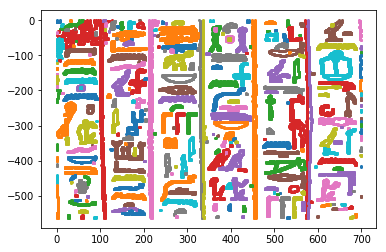

In [664]:
import matplotlib.pyplot as plt

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0,1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    
    class_member_mask = (labels == k)
    
    xy = coordinates[class_member_mask & core_samples_mask]
    plt.plot(xy[:,0],-xy[:,1],'o', markersize=2)
    
plt.show()

In [56]:
canvas = np.zeros_like(img)

for cluster in result_dbscan[1]:
    
    for pixel in result_dbscan[1][cluster]:
        canvas[pixel[1]][pixel[0]] = np.array([100+10*cluster,255-cluster,30*cluster])
    cv.rectangle(img, (cluster_dim[cluster][0],cluster_dim[cluster][1]), (cluster_dim[cluster][0]+cluster_dim[cluster][2], cluster_dim[cluster][1]+cluster_dim[cluster][3]), (0,255,0), 0)

#cv.drawContours(img, [np.array(cluster_dict[0]).reshape(-1,1,2).astype(np.int32)], 0, (0,255,0),2 )
cv.imwrite('../examples/example{}_dbscan.png'.format(example), img)



True

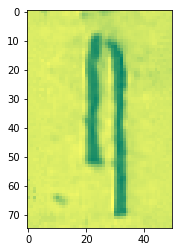

Hieroglyph ? (y/n): y
y


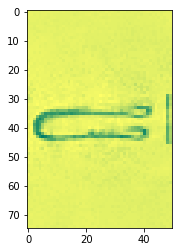

Hieroglyph ? (y/n): h
h
Wrong input. y/n: y


In [30]:
for index in range(2):
    #index = 5
    plt.figure()
    repertory, file = dataHiero['index'][index].split("_")
    label = dataHiero['label'][index]
    picture="/Users/fgimbert/Documents/Dataset/Manual/Preprocessed/"+str(repertory)+"/"+str(file)+"_"+label+".png"

    img = cv.imread(picture)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    plt.imshow(img, cmap="summer")
    plt.show()
    
    a = input('Hieroglyph ? (y/n): ')
    print(a)
    if a not in ['y', 'n']:
        a = input('Wrong input. y/n: ')
    
    

In [29]:
print(a)

y


In [25]:
print(type(a))

<class 'str'>


In [31]:
import cairosvg

/Users/fgimbert/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


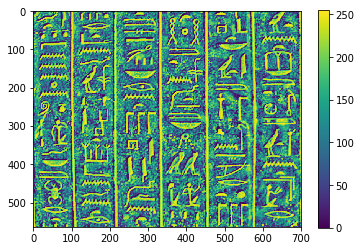

In [27]:
from skimage.morphology import disk
from skimage import color
from skimage import filters
from skimage import io

example = 4
picture='../examples/{}'.format(examples[example])
img = io.imread(picture)

from skimage import img_as_float
img = img_as_float(img)

equalized = color.rgb2gray(img)

selem = disk(30)
equalized = filters.rank.equalize(equalized, selem=selem)

#blur = cv.GaussianBlur(equalized,(3,3),0)
ret3, otsu = cv.threshold(equalized,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
otsu_blur = auto_canny(otsu)
plt.imshow(equalized)
plt.colorbar()

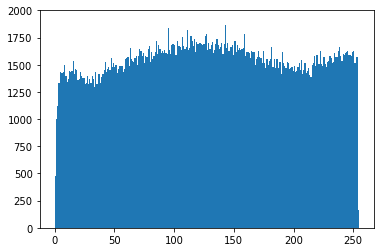

In [90]:
plt.hist(equalized.ravel(), bins=256);
plt.ylim(0, 2000);

In [92]:
seeds = np.zeros_like(equalized)
seeds[equalized < 10] = 1
seeds[(equalized > 140) & (equalized < 200)] = 2
#seeds[(~mask[:, :, 0]).nonzero()] = 3

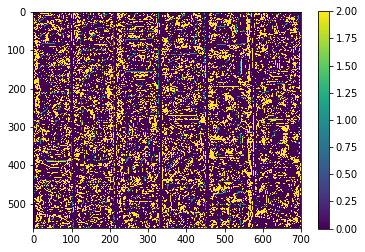

In [93]:
plt.imshow(seeds)
plt.colorbar()

In [15]:
from skimage.morphology import watershed

edges = filters.sobel(equalized)
ws = watershed(edges, seeds)
plt.imshow(ws)

NameError: name 'seeds' is not defined

In [96]:
import scipy.ndimage as ndi
cleaned = np.ones_like(ws)
# signs
cleaned[(ws == 1)] = 0
cleaned = ndi.binary_opening(cleaned)
# border of tablet
cleaned[filters.canny(mask[:, :, 0]) == 1] = 0

AttributeError: module 'skimage.filters' has no attribute 'canny'

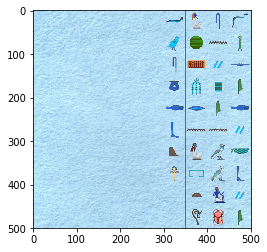

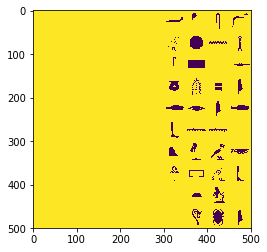

In [19]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import imutils

example=1
image = cv.imread('../examples/{}'.format(examples[example]))
shifted = cv.pyrMeanShiftFiltering(image, 21, 51)
plt.imshow(image)
plt.show()

# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv.cvtColor(shifted, cv.COLOR_BGR2GRAY)
thresh = cv.threshold(gray, 0, 255,cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
plt.imshow(thresh)

In [20]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,labels=thresh)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 23 unique segments found


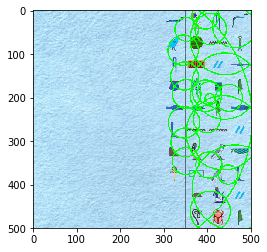

In [21]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
 
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
 
	# detect contours in the mask and grab the largest one
	cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv.contourArea)
 
	# draw a circle enclosing the object
	((x, y), r) = cv.minEnclosingCircle(c)
	cv.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	#cv.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 
# show the output image
plt.imshow(image)

In [285]:
import random
import time
from IPython.display import Image, display, clear_output
from ipywidgets import widgets

x = ['../examples/example4.jpg','../examples/example4.jpg','../examples/example4.jpg','../examples/example4.jpg','../examples/example4.jpg','../examples/example4.jpg']
cluster = 0

def show_img(name):
    img = mpimg.imread('{}'.format(name))
    #img = PIL.Image.open('{}'.format(name))
    #fig, ax =subplots(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img)
   
 
def check_cluster2():

    #print('Cluster ', cluster)
    
    #img = mpimg.imread(picture)
    img = cv.imread(picture)
    x, y, w, h = cv.boundingRect(result_dbscan[1][cluster])
    cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    #print(x, y, w, h)
    #plt.imshow(img)
    cv.imwrite('tempfile.png', img)
    #time.sleep(3)
    
    number_cluster = widgets.Label(value='Cluster   {}'.format(cluster))
    #number_cluster = widgets.Text(value='{}'.format(cluster), description='Cluster',disabled=True)


    button1 = widgets.Button(description = 'Yes', button_style='success')
    button2 = widgets.Button(description = 'No', button_style='danger')
    button3 = widgets.Button(description = 'Maybe', button_style='warning')
    
    container = widgets.VBox(children=[number_cluster, button1,button2,button3])
    w = interactive(show_img, name=fixed(picture))

    file = open('tempfile.png', 'rb')
    image = file.read()
    #w =widgets.Image(value=image, scale=4)
    w = interactive(show_img, name=fixed('tempfile.png'))
    
    screen_select = widgets.HBox(children=[w,container])
    display(screen_select)
    #display(Image('tempfile.png'))
    #display(container)


    def on_button1_clicked(b):
        # [insert code to record choice]
        global cluster
        cluster += 1
        w.close()
        container.close()
        clear_output()
        check_cluster()

    def on_button2_clicked(b):
        # [insert code to record choice] 
        global cluster
        cluster +=1
        w.close()
        container.close()
        clear_output()
        check_cluster()

    def on_button3_clicked(b):
        # [insert code to record choice] 
        global cluster
        cluster +=1
        w.close()
        container.close()
        clear_output()
        check_cluster2()


    button1.on_click(on_button1_clicked)
    button2.on_click(on_button2_clicked)
    button3.on_click(on_button3_clicked)
    
    if cluster ==5:
        print('Job finished')
        screen_select.close()
    
    
check_cluster2() # initializes the first choice

KeyError: 2

In [24]:
import numpy as np